In [1]:
# Random Imports
import os
import sys
import yaml
from pathlib import Path
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

# Regular schema dictates that we put DATAPATH
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
os.environ['WANDB_NOTEBOOK_NAME'] = 'calibrate.ipynb'

from ionpy.util import Config

# Setup direcrtories
root = Path("/storage/vbutoi/scratch/ESE")
scratch_root = Path("/storage/vbutoi/scratch/ESE")
code_root = Path("/storage/vbutoi/projects/ESE")

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

In [2]:
%%yaml default_cfg

data:
  iters_per_epoch: '?' 
  train_splits: cal
  val_splits: val 

dataloader:
  batch_size: '?' # Often, we train with a small num of images total. 
  num_workers: 1
  pin_memory: True 

optim: # Unclear if we should tune this or not.
  _class: torch.optim.Adam
  weight_decay: 0.0 
  lr: 1.0e-4

train:
  epochs: '?' # 10 * 100 = 1000 iterations
  eval_freq: 10 
  pretrained_dir: '?'
  checkpoint: 'max-val-dice_score'
  pretrained_select_metric: 'val-dice_score'

loss_func: 
  _class: '?'
  from_logits: True
  batch_reduction: 'mean' 

<IPython.core.display.Javascript object>

In [3]:
%%yaml callbacks_cfg

callbacks:
  step:
    - ese.experiment.callbacks.ShowPredictions
  epoch:
    - ese.experiment.callbacks.WandbLogger
    - ionpy.callbacks.ETA
    - ionpy.callbacks.JobProgress
    - ionpy.callbacks.TerminateOnNaN
    - ionpy.callbacks.PrintLogged
    - ionpy.callbacks.ModelCheckpoint:
        monitor: ece_loss 
        phase: val

<IPython.core.display.Javascript object>

In [4]:
%%yaml experiment_cfg 

name: "ACDC_CalibrationSuite_LTS_HardGT"


train: 
    pretrained_dir: 
        # - "/storage/vbutoi/scratch/ESE/training/07_09_24_ACDC_PixelCELoss"
        - "/storage/vbutoi/scratch/ESE/training/07_09_24_ACDC_SoftDiceLoss"

model:
    # - TempScaling
    # - ImageBasedTS
    # - PopcornScaling
    - LocalTS

data:
    _class: "ese.experiment.datasets.ACDC"
    label_threshold: 0.5 # Important because we don't have the perfect gt.
    version: 0.1

dataloader:
    batch_size: 8

loss_func:
    _class: 
        - ese.experiment.losses.PixelCELoss
        # - ese.experiment.losses.SoftDiceLoss

optim:
    lr: 1.0e-4 

<IPython.core.display.Javascript object>

In [5]:
from ese.experiment.analysis.analysis_utils.submit_utils import get_ese_calibration_configs

# Get the configs for the different runs.
base_cfg = Config(default_cfg).update([callbacks_cfg])

cal_cfgs = get_ese_calibration_configs(
    exp_cfg=experiment_cfg,
    base_cfg=base_cfg,
    calibration_model_cfgs={}
)

In [6]:
len(cal_cfgs)

8

## Running Jobs

In [7]:
from ese.experiment.experiment import run_ese_exp, submit_ese_exps, PostHocExperiment

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


/storage/vbutoi/projects/ionpy/util/libcheck.py:49: UserWarning: Intel MKL extensions not available for NumPy
  warn("Intel MKL extensions not available for NumPy")
/storage/vbutoi/projects/ionpy/util/libcheck.py:57: UserWarning: Using slow Pillow instead of Pillow-SIMD
  warn("Using slow Pillow instead of Pillow-SIMD")


Set seed: 47
Loading checkpoint: max-val-dice_score.
Running PostHocExperiment("/storage/vbutoi/scratch/ESE/calibration/debug/20240723_144534-G2DC-0e304a5a0f951a14ba7012d8ce40d330")
---
callbacks:
  epoch:
  - ionpy.callbacks.ETA
  - ionpy.callbacks.JobProgress
  - ionpy.callbacks.TerminateOnNaN
  - ionpy.callbacks.PrintLogged
  - ionpy.callbacks.ModelCheckpoint:
      monitor: ece_loss
      phase: val
  step:
  - ese.experiment.callbacks.ShowPredictions
data:
  iters_per_epoch: 1000
  label_threshold: 0.5
  preload: false
  version: 0.1
dataloader:
  batch_size: 8
  num_workers: 1
  pin_memory: true
experiment:
  seed: 47
log:
  checkpoint_freq: 50
  metrics:
    dice_score:
      _fn: ionpy.metrics.dice_score
      batch_reduction: mean
      from_logits: true
      ignore_empty_labels: false
    ece_loss:
      _fn: ese.experiment.metrics.image_ece_loss
      from_logits: true
      num_prob_bins: 15
    edge_ece_loss:
      _fn: ese.experiment.metrics.image_edge_ece_loss
      fro

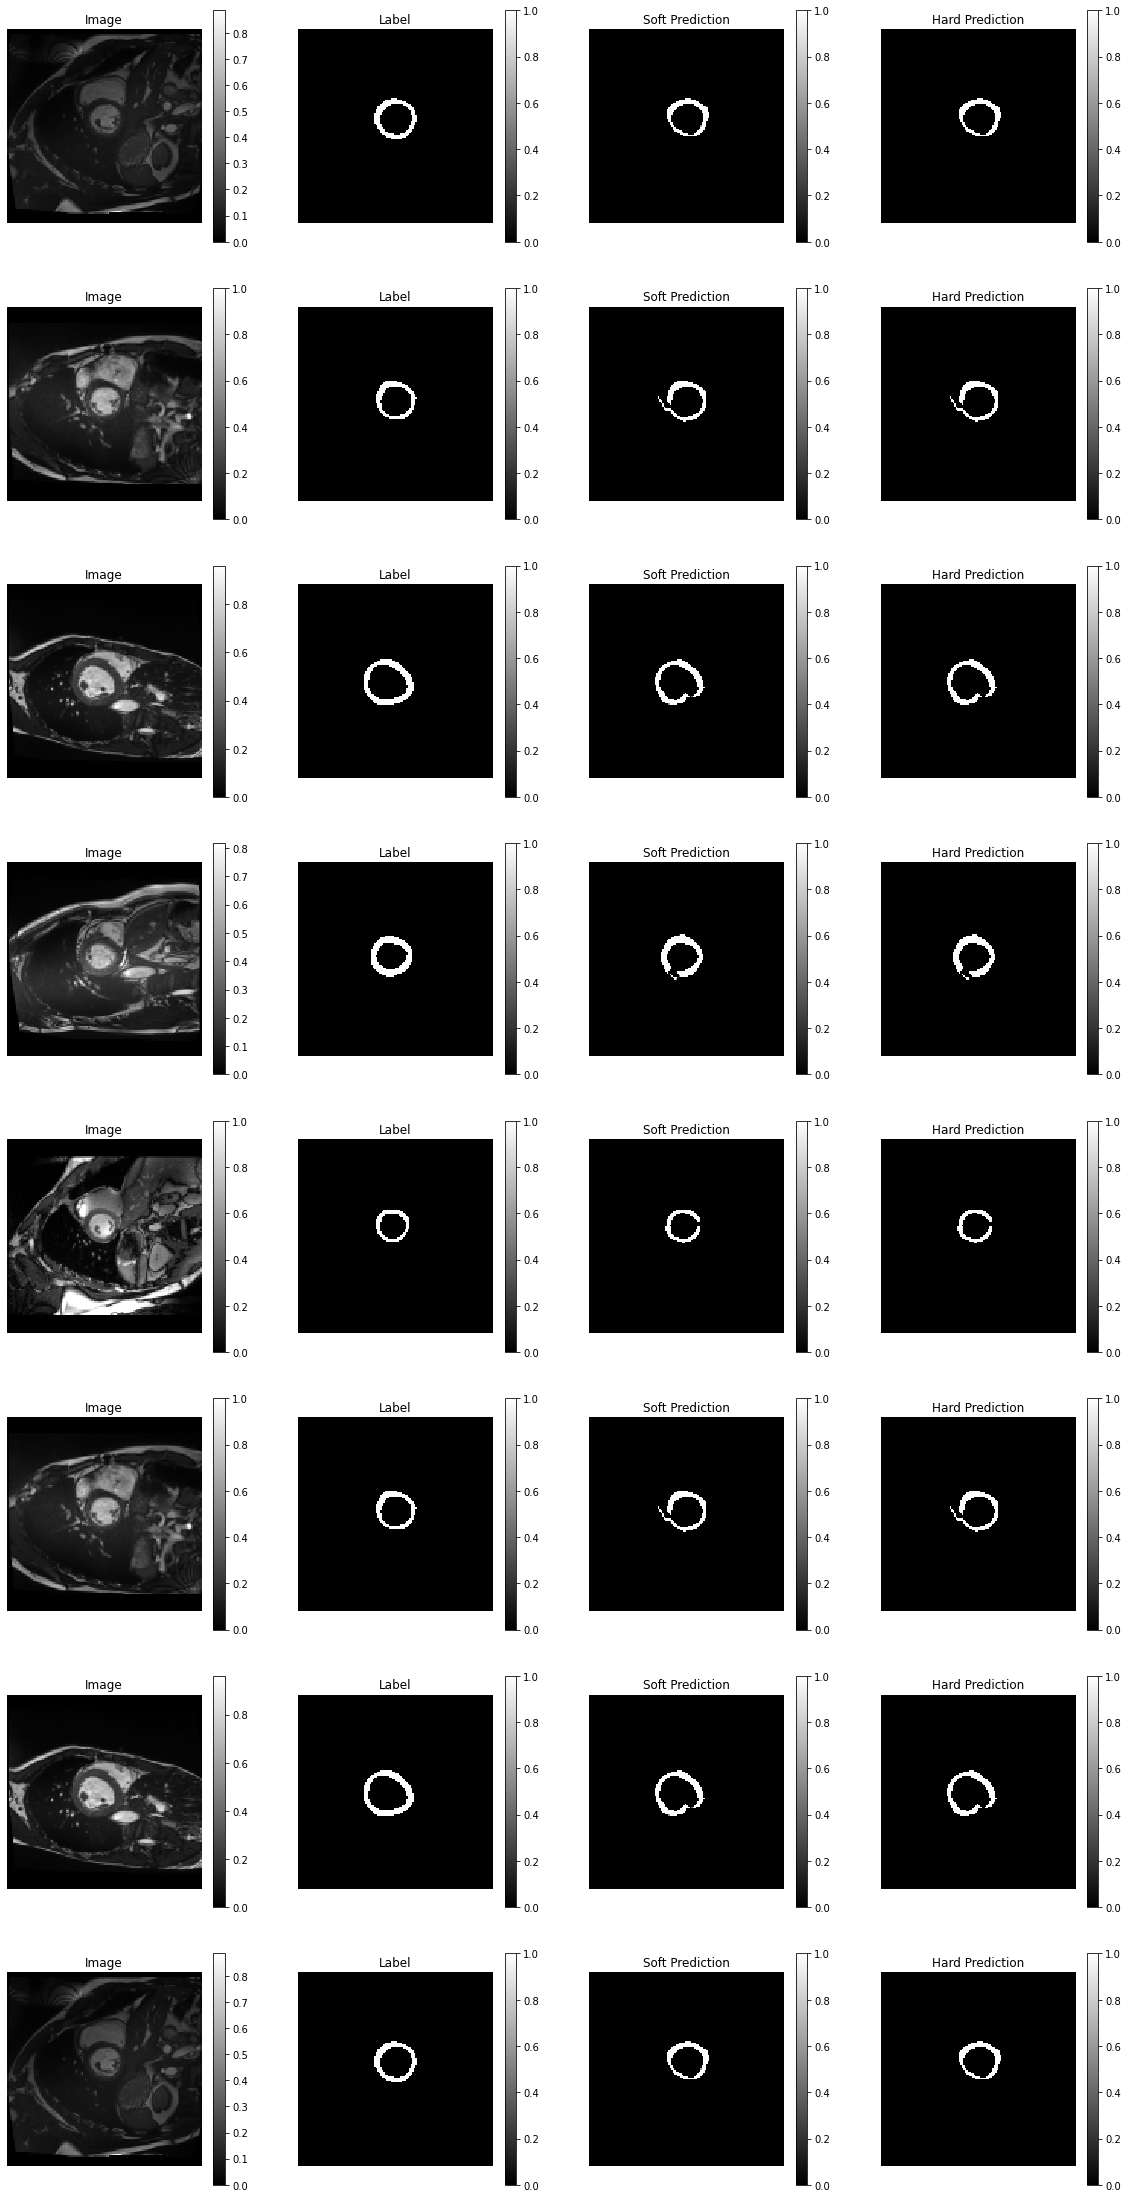

Loss:  38949593088.0


KeyboardInterrupt: 

In [8]:
####### Run individual jobs
run_ese_exp(
    config=cal_cfgs[0], 
    experiment_class=PostHocExperiment,
    run_name='debug',
    show_examples=True,
    track_wandb=False,
    gpu='0',
)

In [ ]:
# ##### Run Batch Jobs
# submit_ese_exps(
#     config_list=cal_cfgs,
#     experiment_class=PostHocExperiment,
#     track_wandb=True,
#     available_gpus=['0', '1', '2', '3']
# )